In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm

# 数据融合

In [2]:
blocks = ["Suzhouqiao", "Wanliu", "Beitaipingzhuang", "Shijicheng"]
dfs_sales = []
dfs_rent = []

In [3]:
# 读取每个文件
for block in blocks:
    filename = f"Beijing_{block}_Sales.csv"
    try:
        df = pd.read_csv(filename)
        df['unit_price'] = df['total_price']/df['area']
        df['block'] = block
        dfs_sales.append(df)
        print(f"成功读取并处理文件: {filename}")
    except FileNotFoundError:
        print(f"错误: 文件 {filename} 未找到")
    except Exception as e:
        print(f"处理文件 {filename} 时发生错误: {str(e)}")

# 拼接数据
if dfs_sales:
    sales = pd.concat(dfs_sales, ignore_index=True)
    print(f"二手房数据合并完成，总记录数: {len(sales)}")
else:
    print("没有成功读取任何数据，无法进行合并")
    combined_df = None

成功读取并处理文件: Beijing_Suzhouqiao_Sales.csv
成功读取并处理文件: Beijing_Wanliu_Sales.csv
成功读取并处理文件: Beijing_Beitaipingzhuang_Sales.csv
成功读取并处理文件: Beijing_Shijicheng_Sales.csv
二手房数据合并完成，总记录数: 2880


In [4]:
# 读取每个文件
for block in blocks:
    filename = f"Beijing_{block}_Rent.csv"
    try:
        df = pd.read_csv(filename)
        df['unit_price'] = df['total_price']/df['area']
        df['block'] = block
        dfs_rent.append(df)
        print(f"成功读取并处理文件: {filename}")
    except FileNotFoundError:
        print(f"错误: 文件 {filename} 未找到")
    except Exception as e:
        print(f"处理文件 {filename} 时发生错误: {str(e)}")

# 拼接数据
if dfs_rent:
    rent = pd.concat(dfs_rent, ignore_index=True)
    print(f"租房数据合并完成，总记录数: {len(rent)}")
else:
    print("没有成功读取任何数据，无法进行合并")
    combined_df = None

成功读取并处理文件: Beijing_Suzhouqiao_Rent.csv
成功读取并处理文件: Beijing_Wanliu_Rent.csv
成功读取并处理文件: Beijing_Beitaipingzhuang_Rent.csv
成功读取并处理文件: Beijing_Shijicheng_Rent.csv
租房数据合并完成，总记录数: 4154


In [5]:
print(sales)

        area  total_price     unit_price       block
0      91.28      7200000   78878.177038  Suzhouqiao
1      57.00      3550000   62280.701754  Suzhouqiao
2      58.70      4800000   81771.720613  Suzhouqiao
3      56.70      3980000   70194.003527  Suzhouqiao
4     254.00     12550000   49409.448819  Suzhouqiao
...      ...          ...            ...         ...
2875  156.47     12600000   80526.618521  Shijicheng
2876  173.00     17000000   98265.895954  Shijicheng
2877  161.00     17700000  109937.888199  Shijicheng
2878  209.00     21000000  100478.468900  Shijicheng
2879  186.00     19500000  104838.709677  Shijicheng

[2880 rows x 4 columns]


In [6]:
print(rent)

      area  total_price  unit_price       block
0       66        10200  154.545455  Suzhouqiao
1       74        15000  202.702703  Suzhouqiao
2       85        12500  147.058824  Suzhouqiao
3       63         7300  115.873016  Suzhouqiao
4       18         4260  236.666667  Suzhouqiao
...    ...          ...         ...         ...
4149   161        19000  118.012422  Shijicheng
4150   195        22000  112.820513  Shijicheng
4151   172        18500  107.558140  Shijicheng
4152   125        17000  136.000000  Shijicheng
4153   184        17000   92.391304  Shijicheng

[4154 rows x 4 columns]


# 描述性统计与预处理

## 描述性统计和异常值处理

In [7]:
def process_data(df, data_name):
    # 存储处理后的数据
    processed_dfs = []
    
    for block in blocks:
        # 筛选当前block的数据
        block_data = df[df['block'] == block].copy()
        print(f"\n处理block: {block}, type: {data_name} 原始数据行数: {len(block_data)}")
        
        # 描述性统计
        stats = block_data.describe()
        print(f"\n{block}的{data_name}数据描述性统计:")
        print(stats)
        
        # 对每个数值列应用3σ原则检测异常值
        numeric_cols = block_data.select_dtypes(include=[np.number]).columns
        outlier_mask = pd.Series(False, index=block_data.index)
        
        for col in numeric_cols:
            # 计算均值和标准差
            mean = block_data[col].mean()
            std = block_data[col].std()
            
            # 3σ原则：超出[mean-3*std, mean+3*std]范围的值为异常值
            col_outliers = (block_data[col] < (mean - 3 * std)) | (block_data[col] > (mean + 3 * std))
            outlier_mask = outlier_mask | col_outliers
            
            # 统计当前列的异常值数量
            col_outlier_count = col_outliers.sum()
            if col_outlier_count > 0:
                print(f"列'{col}'中检测到{col_outlier_count}个异常值")
        
        # 剔除异常值
        cleaned_data = block_data[~outlier_mask]
        outlier_count = len(block_data) - len(cleaned_data)
        print(f"共检测到{outlier_count}个异常值，剔除后剩余{len(cleaned_data)}行数据")
        
        # 添加到处理后的数据列表
        processed_dfs.append(cleaned_data)
        
    # 合并所有处理后的block数据
    result_df = pd.concat(processed_dfs, ignore_index=True)
    print(f"\n{data_name}数据处理完成，原始总数据行数: {len(df)}, 处理后总数据行数: {len(result_df)}")
    
    return result_df

In [8]:
processed_sales = process_data(sales, "二手房")
processed_rent = process_data(rent, "租房")


处理block: Suzhouqiao, type: 二手房 原始数据行数: 311

Suzhouqiao的二手房数据描述性统计:
             area   total_price     unit_price
count  311.000000  3.110000e+02     311.000000
mean    89.096334  6.891672e+06   79486.606641
std     61.586908  4.477599e+06   12908.368936
min     26.800000  2.400000e+06   49333.333333
25%     56.000000  4.335000e+06   70782.774209
50%     66.910000  5.300000e+06   78669.482577
75%     92.200000  7.680000e+06   86338.932806
max    337.400000  3.200000e+07  152985.074627
列'area'中检测到9个异常值
列'total_price'中检测到6个异常值
列'unit_price'中检测到2个异常值
共检测到14个异常值，剔除后剩余297行数据

处理block: Wanliu, type: 二手房 原始数据行数: 1175

Wanliu的二手房数据描述性统计:
              area   total_price     unit_price
count  1175.000000  1.175000e+03    1175.000000
mean    186.761821  3.166600e+07  154790.899279
std      90.679777  2.417384e+07   44992.552987
min      44.170000  2.380000e+06   43709.825528
25%     127.200000  1.650000e+07  127131.782946
50%     160.000000  2.380000e+07  141983.398864
75%     230.010000  3.500

## 计算price to rent ratio与绘图

In [9]:
# 计算中位数
median_list=[]
for block in blocks:
    sales_median = processed_sales[processed_sales['block']==block]['unit_price'].median()
    rent_median = processed_rent[processed_rent['block']==block]['unit_price'].median()
    ratio_median = sales_median/rent_median
    median_list.append({
        "block":block,
        "sales_median":sales_median,
        "rent_median":rent_median,
        "ratio_median":ratio_median
    })
result_median = pd.DataFrame(median_list)

In [10]:
def draw_bar_plot(df):
    
    # 绘制柱状图
    plt.rcParams["font.family"] = ["SimHei"]
    plt.figure(figsize=(12, 6))
    bars = plt.bar(df['block'], df['ratio_median'], color='skyblue')

    # 添加标题和轴标签
    plt.title('各街区房价租金比中位数', fontsize=15)
    plt.xlabel('街区', fontsize=12)
    plt.ylabel('房价租金比中位数', fontsize=12)

    # 旋转x轴标签以防重叠
    plt.xticks(rotation=45, ha='right')

    # 添加数值标签
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2f}',ha='center', va='bottom', rotation=0)

    # 添加参考线
    plt.axhline(y=200, color='red', linestyle='--', label='Global Fair Value')

    # 调整布局
    plt.tight_layout()

    # 显示图例
    plt.legend()

    return plt

              block   sales_median  rent_median  ratio_median
0        Suzhouqiao   78431.372549   126.036683    622.290042
1            Wanliu  141921.397380   148.888889    953.203415
2  Beitaipingzhuang   89942.528736   131.827210    682.275905
3        Shijicheng  109854.014599   108.433735   1013.098135


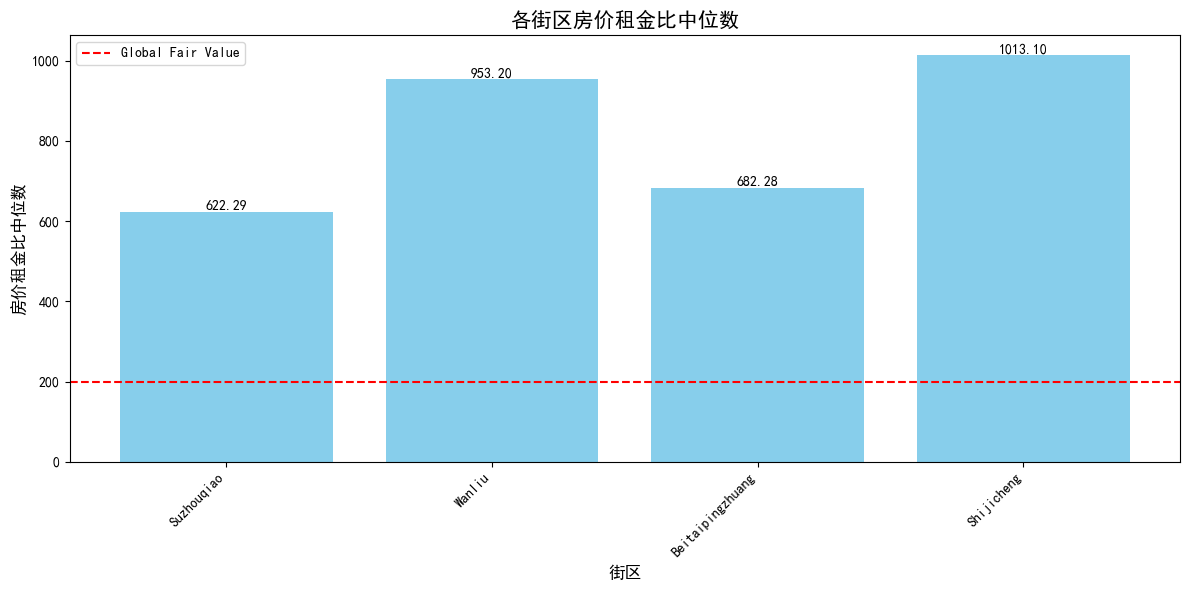

In [11]:
print(result_median)
draw_bar_plot(result_median).show()

# 线性回归：Model 1 & Model 2

## Model 1

In [12]:
# 数据处理：对block独热编码 + 拆分回归X和Y
# 独热编码
encoder = OneHotEncoder(sparse_output=False, drop='first')
block_encoded_1 = encoder.fit_transform(processed_sales[['block']])
block_dummies_1 = pd.DataFrame(block_encoded_1, columns=encoder.get_feature_names_out(['block']),index=processed_sales.index)

# 获取X和Y
X_1 = pd.concat([processed_sales['area'], block_dummies_1], axis=1)
X_1 = sm.add_constant(X_1)
Y_1 = processed_sales['unit_price']

In [13]:
# 执行OLS回归
model_1 = sm.OLS(Y_1, X_1).fit()
print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:             unit_price   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.597
Method:                 Least Squares   F-statistic:                     1047.
Date:                Thu, 16 Oct 2025   Prob (F-statistic):               0.00
Time:                        01:12:38   Log-Likelihood:                -32807.
No. Observations:                2829   AIC:                         6.562e+04
Df Residuals:                    2824   BIC:                         6.565e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             5.618e+04   2099.999  

## Model 2

In [14]:
# 数据处理：对block独热编码 + 拆分回归X和Y
# 独热编码
encoder = OneHotEncoder(sparse_output=False, drop='first')
block_encoded_2 = encoder.fit_transform(processed_rent[['block']])
block_dummies_2 = pd.DataFrame(block_encoded_2, columns=encoder.get_feature_names_out(['block']),index=processed_rent.index)

# 获取X和Y
X_2 = pd.concat([processed_rent['area'], block_dummies_2], axis=1)
X_2 = sm.add_constant(X_2)
Y_2 = processed_rent['unit_price']

In [15]:
# 执行OLS回归
model_2 = sm.OLS(Y_2, X_2).fit()
print(model_2.summary())

                            OLS Regression Results                            
Dep. Variable:             unit_price   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     501.0
Date:                Thu, 16 Oct 2025   Prob (F-statistic):               0.00
Time:                        01:12:38   Log-Likelihood:                -20248.
No. Observations:                3969   AIC:                         4.051e+04
Df Residuals:                    3964   BIC:                         4.054e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              124.3457      2.605  

## 模型应用

In [16]:
# 创建sales_price列：processed_sales['unit_price'] + model_1.predict(X_2)
sales_price = pd.concat([
    processed_sales['unit_price'], 
    pd.Series(model_1.predict(X_2), name='unit_price')  # 确保列名一致
], ignore_index=True)

# 创建rent_price列：model_2.predict(X_1) + processed_rent['unit_price']
rent_price = pd.concat([
    pd.Series(model_2.predict(X_1), name='unit_price'),  # 确保列名一致
    processed_rent['unit_price']
], ignore_index=True)

# 创建block列：processed_sales['block'] + processed_rent['block']
block = pd.concat([
    processed_sales['block'], 
    processed_rent['block']
], ignore_index=True)

# 创建新的DataFrame
all_house_1 = pd.DataFrame({
    'sales_price': sales_price,
    'rent_price': rent_price,
    'block': block
})
all_house_1['ratio'] = all_house_1['sales_price']/all_house_1['rent_price']

In [17]:
print("新DataFrame的形状:", all_house_1.shape)
print(all_house_1.head())

新DataFrame的形状: (6798, 4)
    sales_price  rent_price       block       ratio
0  78878.177038  137.665080  Suzhouqiao  572.971569
1  62280.701754  130.985097  Suzhouqiao  475.479296
2  81771.720613  131.316368  Suzhouqiao  622.707754
3  70194.003527  130.926637  Suzhouqiao  536.132333
4  49409.448819  169.373565  Suzhouqiao  291.718774


In [18]:
# 计算每个block的price to rent ratio中位数
median_list_1 = []
for block in blocks:
    block_data = all_house_1[all_house_1['block'] == block]
    ratio_median = block_data['ratio'].median()
    median_list_1.append({
        "block":block,
        "ratio_median":ratio_median
    })
result_median_1 = pd.DataFrame(median_list_1)

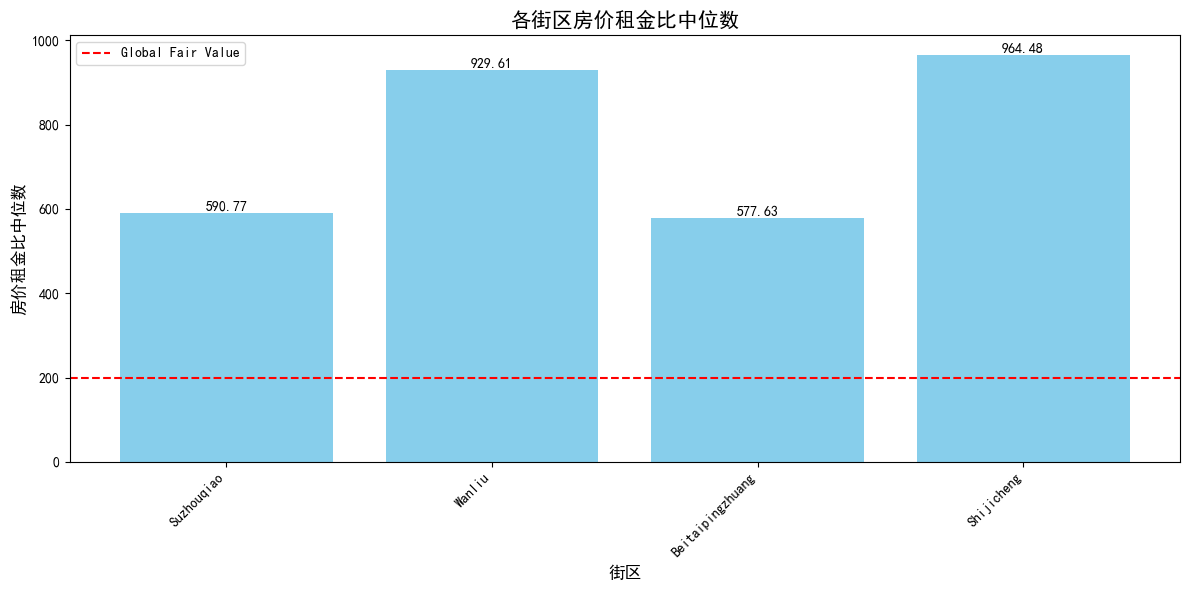

In [19]:
draw_bar_plot(result_median_1).show()

# 线性回归：Model 1+ & Model 2+

## Model 1+

In [20]:
# 数据处理：对block独热编码 + 引入非线性项&交叉项 + 拆分回归X和Y
# 独热编码
encoder = OneHotEncoder(sparse_output=False, drop='first')
block_encoded_3 = encoder.fit_transform(processed_sales[['block']])
block_dummies_3 = pd.DataFrame(block_encoded_3, columns=encoder.get_feature_names_out(['block']),index=processed_sales.index)

# 获取X和Y
X_3 = pd.concat([processed_sales['area'], block_dummies_3], axis=1)
X_3['area2'] = X_3['area']**2
X_3['area x Shijicheng'] = X_3['area']*X_3['block_Shijicheng']
X_3['area x Suzhouqiao'] = X_3['area']*X_3['block_Suzhouqiao']
X_3['area x Wanliu'] = X_3['area']*X_3['block_Wanliu']
X_3 = sm.add_constant(X_3)
Y_3 = processed_sales['unit_price']

In [21]:
# 执行OLS回归
model_3 = sm.OLS(Y_3, X_3).fit()
print(model_3.summary())

                            OLS Regression Results                            
Dep. Variable:             unit_price   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     668.4
Date:                Thu, 16 Oct 2025   Prob (F-statistic):               0.00
Time:                        01:12:39   Log-Likelihood:                -32589.
No. Observations:                2829   AIC:                         6.520e+04
Df Residuals:                    2820   BIC:                         6.525e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              8.449e+04   3792.93

## Model 2+

In [22]:
# 数据处理：对block独热编码 + 引入非线性项&交叉项 + 拆分回归X和Y
# 独热编码
encoder = OneHotEncoder(sparse_output=False, drop='first')
block_encoded_4 = encoder.fit_transform(processed_rent[['block']])
block_dummies_4 = pd.DataFrame(block_encoded_4, columns=encoder.get_feature_names_out(['block']),index=processed_rent.index)

# 获取X和Y
X_4 = pd.concat([processed_rent['area'], block_dummies_4], axis=1)
X_4['area2'] = X_4['area']**2
X_4['area x Shijicheng'] = X_4['area']*X_4['block_Shijicheng']
X_4['area x Suzhouqiao'] = X_4['area']*X_4['block_Suzhouqiao']
X_4['area x Wanliu'] = X_4['area']*X_4['block_Wanliu']
X_4 = sm.add_constant(X_4)
Y_4 = processed_rent['unit_price']

In [23]:
# 执行OLS回归
model_4 = sm.OLS(Y_4, X_4).fit()
print(model_4.summary())

                            OLS Regression Results                            
Dep. Variable:             unit_price   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     279.8
Date:                Thu, 16 Oct 2025   Prob (F-statistic):               0.00
Time:                        01:12:39   Log-Likelihood:                -20171.
No. Observations:                3969   AIC:                         4.036e+04
Df Residuals:                    3960   BIC:                         4.042e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               154.1607      5.14

## 模型应用

In [24]:
# 创建sales_price列：processed_sales['unit_price'] + model_3.predict(X_4)
sales_price = pd.concat([
    processed_sales['unit_price'], 
    pd.Series(model_3.predict(X_4), name='unit_price')  # 确保列名一致
], ignore_index=True)

# 创建rent_price列：model_4.predict(X_3) + processed_rent['unit_price']
rent_price = pd.concat([
    pd.Series(model_4.predict(X_3), name='unit_price'),  # 确保列名一致
    processed_rent['unit_price']
], ignore_index=True)

# 创建block列：processed_sales['block'] + processed_rent['block']
block = pd.concat([
    processed_sales['block'], 
    processed_rent['block']
], ignore_index=True)

# 创建新的DataFrame
all_house_2 = pd.DataFrame({
    'sales_price': sales_price,
    'rent_price': rent_price,
    'block': block
})
all_house_2['ratio'] = all_house_2['sales_price']/all_house_2['rent_price']

In [25]:
print("新DataFrame的形状:", all_house_2.shape)
print(all_house_2.head())

新DataFrame的形状: (6798, 4)
    sales_price  rent_price       block        ratio
0  78878.177038  113.784401  Suzhouqiao   693.224876
1  62280.701754  137.088318  Suzhouqiao   454.310787
2  81771.720613  135.956742  Suzhouqiao   601.453956
3  70194.003527  137.287747  Suzhouqiao   511.291103
4  49409.448819  -10.784383  Suzhouqiao -4581.574189


In [26]:
# 计算每个block的price to rent ratio中位数
median_list_2 = []
for block in blocks:
    block_data = all_house_2[all_house_2['block'] == block]
    ratio_median = block_data['ratio'].median()
    median_list_2.append({
        "block":block,
        "ratio_median":ratio_median
    })
result_median_2 = pd.DataFrame(median_list_2)

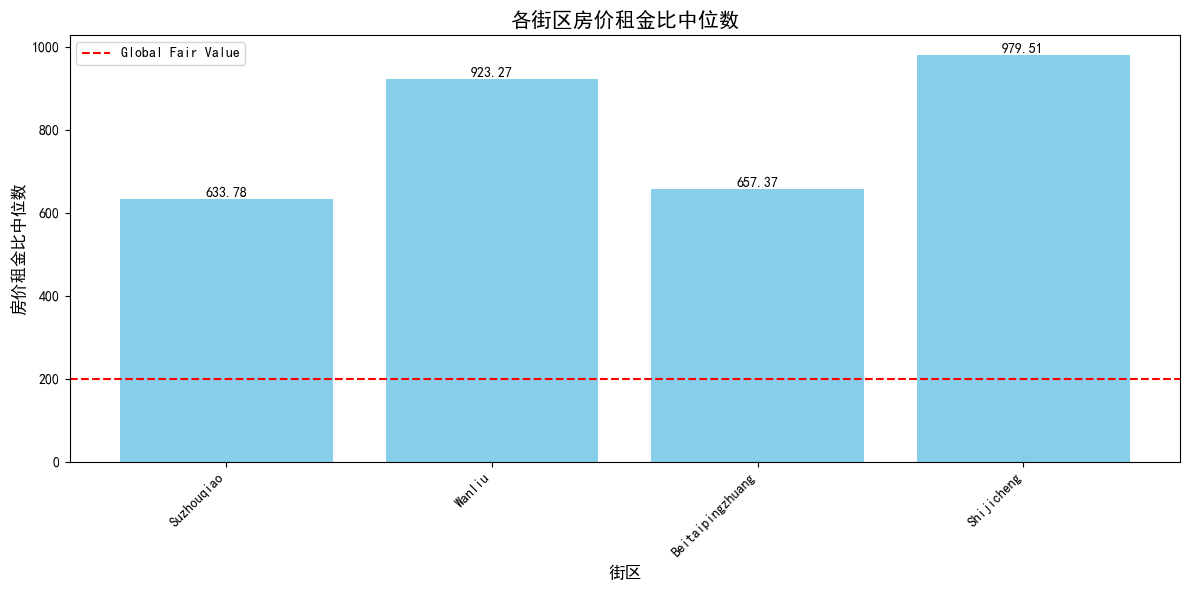

In [27]:
draw_bar_plot(result_median_2).show()

# 比较模型

我认为第三个模型（Model 1+/2+）所得的房价租金比更可信。第一个模型虽然基于实际观测值，但由于无法获得同一个房屋的房价和租金，是采用若干房屋的房价中位数除以若干房屋的租金中位数得到的比值，这种做法在一定程度上忽略了房屋的个体差异性，所得值的可信度有待商榷。第二、三个模型都通过线性回归模型预测的方法，得到所有房屋的房价和租金，然后计算每个房屋的房价租金比，取中位数。相比于第二个模型，第三个模型引入了非线性项（如平方项）、交叉项（如block独热编码和房屋面积的交叉项），使得预测模型能够考虑到更多影响单价的因素，如面积对单价影响的边际效应（通过面积和面积的平方项）、不同block中面积对单价的不同影响（通过交叉项）等，能够更好的拟合。同时考虑到二手房和租房的样本量均较大，更多自变量的引入不会显著的改变模型的过拟合程度。因此，我认为第三个模型（Model 1+/2+）所得的房价租金比更可信。